# Part 0

## 0. Import

In [30]:
import numpy  as np
import pandas as pd
from   scipy.interpolate import interp1d
from   scipy.interpolate import interp2d
from   scipy.misc import derivative
from   scipy import optimize
import astropy.units as u
# import astropy.constants as c
from   astropy.cosmology import FlatLambdaCDM, z_at_value
from   tqdm import *
from   sympy import *
from   astropy.cosmology import Planck13 as cosmo
from   astropy import constants as const
import sys
from   scipy.interpolate import interp1d
from   scipy.interpolate import interp2d
from   scipy.special import zeta
import pickle

import matplotlib.pyplot as plt
from   matplotlib import ticker
from matplotlib import gridspec
import matplotlib.pylab as pylab

sys.path.insert(1, '../packages')
import units

import time



from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')



## Constants and Functions (General)


In [31]:

# Fundamental Constants
h = 4.135667696*1e-15          # in eV s

hbar = h / (2*np.pi)           # in eV s

c = 2.99792458*1e10            # in cm/s

mpl = 1.2209 * 10**19 * 10**9  # in eV

# Defined by X.G

# Consistent with MMA
cm_to_m     = 10**(-2)
cm_to_km    = 10**(-5)

m_to_cm     = 1/cm_to_m
km_to_cm    = 1/cm_to_km

pc_to_cm    = 3.08567758149137* 10**18
Mpc_to_cm   = 10**6 * pc_to_cm

cmInv_to_eV = hbar*c
sInv_to_eV  = hbar
eV_to_J     = 1.602176634 * 10**(-19)
kB_to_JperK = 1.38064852 * 10**(-23)

eV_to_K = eV_to_J/kB_to_JperK

J = 1/eV_to_J  # in eV
K = 1/eV_to_K  # in eV

# Cosmological Constants

# Planck 2018 paper VI Table 2 Final column (68% confidence interval) 1807.06209
planck18_cosmology = {'Oc0': 0.2607,
                              'Ob0': 0.04897,
                              'Om0': 0.3111,
                              'Hubble0': 67.66,
                              'n': 0.9665,
                              'sigma8': 0.8102,
                              'tau': 0.0561,
                              'z_reion': 7.82,
                              't0': 13.787,
                              'Tcmb0': 2.7255,
                              'Neff': 3.046,
                              'm_nu': [0., 0., 0.06],
                              'z_recomb': 1089.80,
                              'reference': "Planck 2018 results. VI. Cosmological Parameters, "
                                           "A&A, submitted, Table 2 (TT, TE, EE + lowE + lensing + BAO)"
                              }


# TCMB_0 from Planck 2018
TCMB_0   = planck18_cosmology["Tcmb0"]*K # in eV


# H = h_Hubble * 100 km/s/Mpc
# Note: 'h' is already used for Planck constant before
h_Hubble = planck18_cosmology["Hubble0"]/100

H0       = h_Hubble * ( 100 * km_to_cm * sInv_to_eV/ Mpc_to_cm )   # in eV

# Fraction of matter
Omega_m  = planck18_cosmology["Om0"]

# Fraction of radiation
Omega_r = (8*np.pi**3/90) * 3.38 * (TCMB_0**4/(mpl**2 * H0**2))

# Fraction of dark energy
Omega_Lambda = 1 - Omega_r - Omega_m

# Baryon-to-photon ratio, from 1912.01132
eta = 6.129 * 10**(-10)

# Helium-to-hydrogen mass fraction, from 1912.01132
Yp  = 0.247

# np at z=0
# (np includes the proton inside Helium)
np0 = (1-Yp/2) * eta * (2*zeta(3)/np.pi**2) * ( TCMB_0 / cmInv_to_eV )**3 # in cm^-3

# nH at z=0
# (nH is the neutral+ionized Hydrogen number density)
nH0 = (1-Yp) * eta * (2*zeta(3)/np.pi**2) * ( TCMB_0 / cmInv_to_eV )**3 # in cm^-3

Xe_smallz = 1.16518752

# ne at z=0
# Comment1 : We can also use ne0=np0 because of one-to-one map between electon and proton
# Comment2 : Numerically, we can very that nH0 * Xe_smallz = np0 (as expected)
ne0 = nH0 * Xe_smallz   # in cm^-3


m_e = 0.511 * 10**6 # in eV

# From PDG
alpha = 1/137.035999084

ee = np.sqrt(4*np.pi*alpha)

# Thompson Scattering Cross Section (Double-checked with Wiki)
thomson_xsec = 6.6524587158e-25   # cm^2

# electron’s Compton wavelength (Double-checked with Wiki)
lambda_e = 2.426e-10   # in cm


# mA^2 at z=0
mASq0 = ee**2 * (ne0 * cmInv_to_eV**3)/m_e  # in eV^2

# ========================================================
# x_e function defined by A.C
# ========================================================

x_e_data = pickle.load(open("../data/std_soln_He.p", "rb"))

def x_e(z):
    
    return np.interp(z, np.flipud(x_e_data[0]) - 1.0, np.flipud(x_e_data[2]))

# Hubble Parameter
# in eV
def hubble(z):
    
    return H0 * np.sqrt(Omega_Lambda + Omega_m * (1.0 + z) ** 3 + Omega_r * (1.0 + z) ** 4)

## Constants and Functions (Special)

$\alpha_\rho= \frac{\zeta(3)}{3 \zeta(4)} \simeq 0.3702$

$\alpha_\mu = \frac{\zeta(2)}{3\zeta(3)}  \simeq 0.456$

$x_0 = \frac{4}{3 \alpha_\rho} = \frac{4\zeta(4)}{\zeta(3)} \simeq 3.6$

$\kappa_c = \frac{45}{\pi^4} \left( \frac{2 \pi^6}{ 135 \zeta(3) } - 6 \zeta(3) \right) \simeq 2.14185$

$\rho_\gamma(T) = \frac{g_\gamma \pi^2}{30} T^4 = \frac{\pi^2}{15} T^4$

$$$$

$\gamma \rightarrow A'$ at RAD: 

$1+z_\text{res} \simeq \left(\frac{m_{A'}^2}{ m_\gamma^2|_{z=0} }\right)^{1/3}$

$P_{\gamma \rightarrow A'} \simeq \frac{1}{x'} F, \quad \text{where}\,\, F = \frac{\pi \epsilon^2 m_\gamma^2|_{z=0}}{ 3 \sqrt{\Omega_r} H_0 T_0 }.$

In [32]:
alpha_rho = zeta(3)/(3*zeta(4))
alpha_mu  = zeta(2)/(3*zeta(3))
x_0 = (4*zeta(4))/zeta(3)
kappa_c = (45/np.pi**4)*( 2*np.pi**6/(135*zeta(3)) - 6*zeta(3) )

# Definition of F/eps^2 (Dimensionless): A->Ap Transition
F_over_eps2_RAD = np.pi * mASq0 / ( 3 * np.sqrt(Omega_r) * H0 * TCMB_0 )
F_over_eps2_RAD_Andrea = 2 * np.pi * 1.4e-21 * ne0 / (6. * TCMB_0 * H0 * np.sqrt(Omega_r))


# P_AToAp/eps^2 for RAD universe(Approx)
def P_over_eps2_RAD(x):
    
    P_over_eps2 = (1/x) * F_over_eps2_RAD
    
    return P_over_eps2


# z_res for RAD universe(Approx)
def zres_RAD(m_Aprime):
    
    zres = (m_Aprime**2/mASq0)**(1/3) - 1
    
    return zres


# m_Aprime_res for RAD universe(Approx)
def m_Aprime_res_RAD(z_res):
    
    m_Aprime_res = np.sqrt( mASq0 * (1+z_res)**3 )
    
    return m_Aprime_res   # in eV


def rho_gamma(T):
    
    return (np.pi**2/15) * T**4

### Covariance Matrix
maybe move this somwhere else

In [33]:
# Import COBE-FIRAS data (From astro-ph/9605054)
import pandas as pd

FIRAS_data_ary = np.transpose( np.array( pd.read_csv('../data/FIRASData.csv') ) )

# nu [cm^-1]
FIRAS_nu_ary  = np.ndarray.flatten( FIRAS_data_ary[[0]] )

# Intensity [MJy * sr^-1]
FIRAS_I0_ary  = np.ndarray.flatten( FIRAS_data_ary[[1]] )

# Residual [kJy * sr^-1]
FIRAS_res_ary   = np.ndarray.flatten( FIRAS_data_ary[[2]] )

# Uncertainty [kJy * sr^-1]
FIRAS_sigma_ary = np.ndarray.flatten( FIRAS_data_ary[[3]] )


# Q array  ('3.3 Variance Estimation')
Q_ary = np.array([1.000, 0.176, -0.203, 0.145, 0.077, -0.005, -0.022, 0.032,
                          0.053, 0.025, -0.003, 0.007, 0.029, 0.029, 0.003, -
                          0.002, 0.016, 0.020, 0.011, 0.002, 0.007,
                          0.011, 0.009, 0.003, -0.004, -0.001, 0.003, 0.003, -
                          0.001, -0.003, 0.000, 0.003, 0.009, 0.015,
                          0.008, 0.003, -0.002, 0.000, -0.006, -0.006, 0.000, 0.002, 0.008])

# Length of FIRAS data
len_FIRAS = len(FIRAS_nu_ary)

# Smallest frequency in FIRAS data [cm^-1]
FIRAS_nu_min = FIRAS_nu_ary[0]

# Largest frequency in FIRAS data [cm^-1]
FIRAS_nu_max= FIRAS_nu_ary[-1]

# ----------------------------------------------------------------------
# Calc: Cov[i,j] = Q(|i-j|) * sig_i * sig_j
# ----------------------------------------------------------------------

# Covariance Matrix: Initialization
Cov   = np.zeros((len_FIRAS, len_FIRAS))
Cov_2 = np.zeros((len_FIRAS, len_FIRAS))


# Def Covariance by X.G
for i in range(len_FIRAS):
    
    for j in range(len_FIRAS):
        
        # Index of Q array
        # More intuitively, this is the 'distance' between nu_i and nu_j
        idx_Q = np.abs(i-j)
        
        # Q value
        Q_value = Q_ary[idx_Q]
        
        # Cov_ij
        Cov[i,j] = FIRAS_sigma_ary[i] * FIRAS_sigma_ary[j] * Q_value
        

# Def Covariance by Sid
# See https://github.com/smsharma/dark-photons-perturbations/blob/master/grf/grf.py

# array of nu - nu^prime
nu_minus_nu_prime_ary = np.linspace( FIRAS_nu_min , FIRAS_nu_max, len_FIRAS ) - FIRAS_nu_min


for i in range(len_FIRAS):
    
    for j in range(len_FIRAS):
        
        # nu_i - nu_j
        nu_minus_nu_prime = np.abs( FIRAS_nu_ary[i] - FIRAS_nu_ary[j] )
        
        # Index of Q array
        # More intuitively, this is the 'distance' between nu_i and nu_j
        # .argmin() can return the index of the minimal value
        idx_Q = np.abs( nu_minus_nu_prime_ary - nu_minus_nu_prime ).argmin()
        
        # Q value
        Q_value = Q_ary[idx_Q]
        
        # Cov_ij
        Cov_2[i,j] = FIRAS_sigma_ary[i] * FIRAS_sigma_ary[j] * Q_value
        


## Exact $X_e$

In [34]:
# Parameters used in Class
class_parameters = {'H0':         planck18_cosmology["Hubble0"],
                    'Omega_b':    planck18_cosmology["Ob0"],
                    'N_ur':       planck18_cosmology["Neff"],
                    'Omega_cdm':  planck18_cosmology["Oc0"],
                    'YHe':        Yp,
                    'z_reio':     planck18_cosmology["z_reion"]}

# Call class
from classy import Class

CLASS_inst = Class()
CLASS_inst.set(class_parameters)
CLASS_inst.compute()

# z array
z_ary_log     = np.logspace(-6, 8, 100000)
# z_ary_log     = np.logspace(-6, 8, 300000)
# z_ary_log     = np.logspace(-6, 8, 3000000)
# z_ary_log     = np.logspace(-6, 8, 10000000)



# Add 0(today) at the beginning of z_ary
z_ary = np.insert(z_ary_log,0,[0])

# Xe array
Xe_ary   = np.array([ CLASS_inst.ionization_fraction(z) for z in z_ary ])

# XeH array
# (If Xe>=1, replace it with 1)
XeH_ary = np.where(Xe_ary<=1,Xe_ary,1)

# Xe interpolation
Xe_interp  = interp1d(z_ary, Xe_ary, fill_value="extrapolate")

# XeH interpolation
XeH_interp = interp1d(z_ary, XeH_ary, fill_value="extrapolate")

# dXe/dz array
# (with the length of z_ary[:-1])
dXe_dz_ary = np.diff(Xe_ary)/np.diff(z_ary)

# dXeH/dz array
# (with the length of z_ary[:-1])
dXeH_dz_ary = np.diff(XeH_ary)/np.diff(z_ary)


# dXe/dz interpolation
# dXe_dz_interp  = interp1d(z_ary, dXe_dz_ary, fill_value="extrapolate")
dXe_dz_interp  = interp1d(z_ary[:-1], dXe_dz_ary, fill_value="extrapolate")

# # dXeH/dz interpolation
# dXeH_dz_interp  = interp1d(z_ary,  dXeH_dz_ary, fill_value="extrapolate")
dXeH_dz_interp  = interp1d(z_ary[:-1],  dXeH_dz_ary, fill_value="extrapolate")



# n_p function [cm^-3]
def n_p(z):
    
    n_p_0 = (1-Yp/2) * eta * (2*zeta(3)/np.pi**2) * ( TCMB_0 / cmInv_to_eV )**3   # in cm^-3
    
    n_p_z = n_p_0 * (1+z)**3   # in cm^-3
    
    return n_p_z

# n_H function [cm^-3]
def n_H(z):
    
    n_H_0 = (1-Yp) * eta * (2*zeta(3)/np.pi**2) * ( TCMB_0 / cmInv_to_eV )**3   # in cm^-3
    
    n_H_z = n_H_0 * (1+z)**3   # in cm^-3
    
    return n_H_z

# n_e function [cm^-3]
def n_e(z):
    
    n_e_z = Xe_interp(z) * n_H(z)
    
    return n_e_z   # in cm^-3

## $m_\gamma^2(z,\omega_0)$, $d m_\gamma^2/dz(z,\omega_0)$, and $z_\text{cross}$

From arXiv:2002.05165, we have
\begin{equation}
m_\gamma^2(z) = 1.4 \times 10^{-21}\text{eV}^2 X_e(z) \left(\frac{n_\text{H}(z)}{\text{cm}^{-3}}\right)- 8.4 \times 10^{-24} \text{eV}^2 \left(\frac{\omega(z)}{\text{eV}}\right)^2 \left( 1 - X_{e,\text{H}}(z) \right) \left(\frac{ n_\text{H}(z) }{ \text{cm}^{-3} }\right),
\end{equation}

where (Here $n_{e} = n_{e,\text{H}} + n_{e,\text{HI}}$)
\begin{equation}
X_e = \frac{n_{e}}{n_\text{H}} \quad \text{and} \quad X_{e,\text{H}} = \frac{n_{e,\text{H}}}{n_\text{H}},
\end{equation}

and 
\begin{equation}
n_H = (1-Y_p) n_\gamma = (1-Y_p) \times \eta \frac{2 \zeta(3)}{\pi^2} T^3.  
\end{equation}


Doing the derivative over $z$, we have
\begin{equation}
\begin{aligned}
\frac{dm_\gamma^2(z)}{dz} 
& = 1.4 \times 10^{-21}\text{eV}^2 \left[ \frac{dX_e(z)}{dz} + \frac{3 X_e(z)}{1+z} \right] \left(\frac{n_\text{H}(z)}{\text{cm}^{-3}}\right)\\
& \quad - 8.4 \times 10^{-24} \text{eV}^2 \left(\frac{\omega(z)}{\text{eV}}\right)^2 \left[ - \frac{dX_{e,\text{H}}(z)}{dz} + \frac{5\left( 1 - X_{e,\text{H}}(z) \right)}{1+z} \right] \left(\frac{ n_\text{H}(z) }{ \text{cm}^{-3} }\right),
\end{aligned}
\end{equation}

In [35]:
# Plasmon mass^2 [eV^2]
# Input omega0 in eV
def mAsq(z, omega0):
    
    # from free electron
    mAsq_1 = 1.4*10**(-21) * Xe_interp(z) * n_H(z)
    
    # from neutral hydrogen
    mAsq_2 = - 8.4 * 10**(-24) * ( omega0 * (1+z) )**2 * (1-XeH_interp(z) ) * n_H(z)
    
    # total mA^2
    mAsq = mAsq_1 + mAsq_2
    
    return mAsq


# d(Plasmon mass^2)/dz [eV^2]
# Input omega0 in eV
def dmAsq_over_dz(z, omega0):
    
    # from free electron
    dmAsq_over_dz_1 = 1.4*10**(-21)*( dXe_dz_interp(z) + 3*Xe_interp(z)/(1+z) ) * n_H(z)
    
    # from neutral hydrogen
    dmAsq_over_dz_2 = - 8.4 * 10**(-24) * ( omega0 * (1+z) )**2 * ( -dXeH_dz_interp(z) + 5*(1-XeH_interp(z))/(1+z) ) * n_H(z)
    
    # total d(mA^2)/dz
    dmAsq_over_dz = dmAsq_over_dz_1 + dmAsq_over_dz_2
    
    return dmAsq_over_dz


# Get z at A-Ap crossings
# Modified from 'grf.py' file in https://github.com/smsharma/dark-photons-perturbations

# z_ary: Grids to check whether the level crossing exists
# z_ary = np.logspace(-5, 8, 20000)
# np.logspace(-5, 8, 2000)
def get_z_crossings(mAp, omega0, z_ary = np.logspace(-3, 8, 10000)):
    
    # mA^2 on grids
    mAsq_ary = mAsq(z_ary, omega0)
    
    # Find the grid containing level crossing
    # np.where is used to find the position of 'True' in array
    # [:-1] means 1,2,3,...,N-1, [1:] means 2,3,...,N-1,N
    where_ary =  np.where( np.logical_or( 
            (mAsq_ary[:-1]<mAp**2) * (mAsq_ary[1:]>mAp**2), (mAsq_ary[:-1]>mAp**2) * (mAsq_ary[1:]<mAp**2) ) )
    
    # mA^2-mAp^2 on grids
    def mAsq_minus_mApsq_ary(z):
        
        return mAsq(z, omega0) - mAp**2
    
    # We use list, because '.append' can be applied in list, but not array
    z_cross_list = []
    
    # Solve z_cross for each grid containing level crossing
    for i in range(len(where_ary[0])):
        z_cross_list.append(
            optimize.brenth(mAsq_minus_mApsq_ary, z_ary[where_ary[0][i]], z_ary[where_ary[0][i] + 1] ) )
#         z_cross_list.append(
#             optimize.brentq(mAsq_minus_mApsq_ary, z_ary[where_ary[0][i]], z_ary[where_ary[0][i] + 1] ) )

    
    # Make list to array
    z_cross_ary = np.array(z_cross_list)
    
    return z_cross_ary

# Part 1A
## $P_{\gamma \rightarrow A'}$

Perturbative: 
\begin{equation}
P_{\gamma \rightarrow A'}(m_{A'},x) = \sum_\text{res} \frac{\pi \epsilon^2 m_{A'}^4}{ \omega(z_\text{res}) \cdot (1+z_\text{res}) H_\text{res} } \frac{1}{\left| d m_\gamma^2/dz \right|_\text{res}}.
\end{equation}

Non-perturbative: 
\begin{equation}
P_{\gamma \rightarrow A'} = 1 - \exp\left(- \sum_\text{res} \frac{\pi \cdot \sin^2\epsilon \cdot m_{A'}^4}{ \omega(z_\text{res}) \cdot (1+z_\text{res}) H_\text{res} } \frac{1}{\left| d m_\gamma^2/dz \right|_\text{res}} \right)
\end{equation}

In [36]:
# Perturbative P(A->Ap): Needs to input z_res_ary
def P_pre_over_eps2(mAp, x, z_res_ary):
    
    # omega at z=0
    omega0 = x * TCMB_0  # in eV
    
    # omega at z_res
    omega_res_ary = omega0 * (1+z_res_ary) # in eV
    
    # P/eps^2 ary
    P_pre_over_eps2_ary = (np.pi * mAp**4)/( omega_res_ary * (1+z_res_ary) * hubble(z_res_ary) ) * ( 1 / np.abs(dmAsq_over_dz(z_res_ary, omega0)) ) 
    

    
    # P/eps^2
    P_pre_over_eps2  = np.sum(P_pre_over_eps2_ary)
    
    return P_pre_over_eps2


# Perturbative P(A->Ap):  z_res_ary is solved inside
def P_over_eps2(mAp, x):
    
    # omega at z=0
    omega0 = x * TCMB_0  # in eV
    
    # z_res array
    z_res_ary = get_z_crossings(mAp, omega0)
    
    # P_tot
    P_over_eps2 = P_pre_over_eps2(mAp, x, z_res_ary)
    
    return P_over_eps2



In [8]:
# ----------------------------------------------------------------------
# Parameters for scanning in (mAp,x) plane
# ----------------------------------------------------------------------
# Output the P(A->Ap) table on x-mAp plane
N_P_x   = 500
N_P_mAp = 300

# N_P_x   = 1000
# N_P_mAp = 300

nu_P_min = 10**(-2)  # in cm^-1
nu_P_max = 30        # in cm^-1    # Note: The highest nu_FIRAS is 21.33 cm^-1

x_P_min = 2 * np.pi * nu_P_min * cmInv_to_eV/TCMB_0   # in eV
x_P_max = 2 * np.pi * nu_P_max * cmInv_to_eV/TCMB_0   # in eV

mAp_P_min = 10**(-17)                               # in eV     # Note: The lower mAp of FIRAS bound is ~10^(-15) eV
mAp_P_max = 10**(-3)                                # in eV     # Note: mAp~10^-4eV, z_res~10^6 (Double Compton Scattering). 
# mAp_P_max = 0.3*m_Aprime_res_RAD(z_ary_log[-1])   # in eV     # Note: mAp~10^-4eV, z_res~10^6 (Double Compton Scattering). 

# mAp_P_min = 10**(-11)                             # in eV     # Note: The lower mAp of FIRAS bound is ~10^(-15) eV
# mAp_P_max = 10**(-3)                              # in eV     # Note: mAp~10^-4eV, z_res~10^6 (Double Compton Scattering). 

print('N_P_x     = ', N_P_x )
print('N_P_mAp   = ', N_P_mAp )
print('')
print('x_P_min   = ', x_P_min )
print('x_P_max   = ', x_P_max )
print('')
print('mAp_P_min = ', mAp_P_min, 'eV')
print('mAp_P_max = ', mAp_P_max, 'eV')
print('')

# ----------------------------------------------------------------------
# Scan in (x,mAp) plane
# ----------------------------------------------------------------------

x_P_scan_ary   = np.linspace( x_P_min, x_P_max, N_P_x )
mAp_P_scan_ary = np.logspace( np.log10(mAp_P_min), np.log10(mAp_P_max), N_P_mAp )

P_over_eps2_scan_2Dary = np.zeros( (len(x_P_scan_ary),len(mAp_P_scan_ary)) )

for j in tqdm_notebook(range(0,len(mAp_P_scan_ary))):
    
#     if j%20==0: 
#         print('This is ', j, 'th mAp')
        
#     if (j%(N_P_mAp-1)==0) and (j!=0): 
#         print('This is ', j, 'th mAp (Finished)')
    
    for i in range(0,len(x_P_scan_ary)):
        
        x_i   = x_P_scan_ary[i]
        mAp_j = mAp_P_scan_ary[j]   # in eV
        
        # print(x_i,mAp_j)
        
        P_over_eps2_scan_2Dary[i][j] = P_over_eps2(mAp_j, x_i)

N_P_x     =  500
N_P_mAp   =  300

x_P_min   =  0.0052789483668742995
x_P_max   =  15.836845100622897

mAp_P_min =  1e-17 eV
mAp_P_max =  0.001 eV



In [9]:
np.savez("../data/Probability.npz",
         x_P_scan_ary=x_P_scan_ary,
         mAp_P_scan_ary=mAp_P_scan_ary,
         P_over_eps2_scan_2Dary=P_over_eps2_scan_2Dary
         )

In [28]:
# # **********************************************************************
# # Export the result
# # **********************************************************************

# # -------------------------------------------------------
# # x:   1D array
# x_1Dary_P_pdform = pd.DataFrame(x_P_scan_ary)
# x_1Dary_P_pdform.to_excel('res_x_1Dary.xlsx', index=False)


# # -------------------------------------------------------
# # mAp: 1D array
# mAp_1Dary_P_pdform = pd.DataFrame(mAp_P_scan_ary)
# mAp_1Dary_P_pdform.to_excel('res_mAp_1Dary.xlsx', index=False)

# # -------------------------------------------------------
# # P/eps^2: 2D array
# P_over_eps2_pdform  = pd.DataFrame(P_over_eps2_scan_2Dary)
# P_over_eps2_pdform.to_excel('res_P_over_eps2_2Dary.xlsx', index=False)

In [10]:
# # **********************************************************************
# # Import the result
# # **********************************************************************

# # -------------------------------------------------------


# file_name = "../data/Probability.npz"
# if file_name is not None:
#     file = np.load(file_name)
# # x:   1D array
# x_1Dary_P_import = file['x_P_scan_ary']
# # -------------------------------------------------------
# # mAp: 1D array
# mAp_1Dary_P_import = file['mAp_P_scan_ary']

# # -------------------------------------------------------
# # P/eps^2: 2D array
# P_over_eps2_2Dary_import = file['P_over_eps2_scan_2Dary']



In [11]:
# # Log10(P/eps^2)
# # Input: Log10(mAp), x

# Reg_trans= 10**(-100)

# log10P_over_eps2_interp = interp2d( np.log10(mAp_1Dary_P_import), x_1Dary_P_import, np.log10(P_over_eps2_2Dary_import + Reg_trans) )

# # P/eps^2 from 2D interpolation
# # Input: Log10(mAp), x
# def P_over_eps2_interp(mAp, x):
    
#     P_over_eps2_interp = 10**log10P_over_eps2_interp( np.log10(mAp), x )
    
#     return P_over_eps2_interp


# # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# # Test of the Code (1): Check of P/eps^2 from interp (Point Check)
# # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# mAp_test = 1e-13  # eV
# x_test   = 0.3


# P_over_eps2_exact_test  = P_over_eps2( mAp_test, x_test )
# P_over_eps2_interp_test = P_over_eps2_interp( mAp_test, x_test )[0]

# print('----------------------Point Check----------------------')
# print('mAp_test          = ', mAp_test, 'eV')
# print('x_test            = ', x_test)
# print('')
# print( 'P/eps^2 (exact)  = ', P_over_eps2_exact_test )
# print( 'P/eps^2 (interp) = ', P_over_eps2_interp_test )
# print('')
# print('relative error    = ', np.abs(P_over_eps2_exact_test-P_over_eps2_interp_test)/P_over_eps2_interp_test )

# # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# # Test of the Code (2): Check of P/eps^2 from interp (Scan Check)
# # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# N_x_check   = 35
# N_mAp_check = 30

# x_check_ary   = np.linspace( x_P_min, x_P_max, N_x_check )
# mAp_check_ary = np.logspace( np.log10(mAp_P_min), np.log10(mAp_P_max), N_mAp_check )


# interp_error_2Dary = np.zeros( (len(x_check_ary),len(mAp_check_ary)) )

# for j in range(0,len(mAp_check_ary)):
    
#     for i in range(0,len(x_check_ary)):
        
#         x_i   = x_check_ary[i]
#         mAp_j = mAp_check_ary[j]   # in eV
        
#         P_over_eps2_calc_ij = P_over_eps2(mAp_j, x_i)
        
#         P_over_eps2_interp_ij = P_over_eps2_interp(mAp_j, x_i)[0]
        
# #         print('P/eps^2         = ', P_over_eps2_calc_ij)
# #         print('P/eps^2(interp) = ', P_over_eps2_interp_ij)
# #         print('')
        
#         if ( P_over_eps2_interp_ij + P_over_eps2_calc_ij )>= 0.002 :
            
#             interp_error_2Dary[i][j] = 2*( np.abs(P_over_eps2_interp_ij-P_over_eps2_calc_ij) )/( P_over_eps2_interp_ij + P_over_eps2_calc_ij )
        
#         else:
            
#             interp_error_2Dary[i][j] = 0
            
# # The maximum (relative) error
# error_max =  np.max(interp_error_2Dary)

# print('')
# print('----------------------Scan Check----------------------')
# print('mAp_min                = ', mAp_P_min, 'eV')
# print('mAp_max                = ', mAp_P_max, 'eV')
# print('')
# print('x_min                  = ', x_P_min)
# print('x_max                  = ', x_P_max)
# print('')
# print('N_mAp_check            = ', N_mAp_check)
# print('N_x_check              = ', N_x_check)
# print('')
# print('maximum relative error = ', error_max)

----------------------Point Check----------------------
mAp_test          =  1e-13 eV
x_test            =  0.3

P/eps^2 (exact)  =  9929476223.518011
P/eps^2 (interp) =  9940960083.439568

relative error    =  0.001155206320633677

----------------------Scan Check----------------------
mAp_min                =  1e-17 eV
mAp_max                =  0.001 eV

x_min                  =  0.0052789483668742995
x_max                  =  15.836845100622897

N_mAp_check            =  30
N_x_check              =  35

maximum relative error =  0.006689479746237655


In [12]:
# # Black Body Intensity
# def I0(x, T0, units='eV_per_cmSq'):
    
#     if   units == 'eV_per_cmSq': # units:    eV * cm^-2 * sr^-1
#         prefac = 1
#     elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
#         prefac = eV_to_J * (1/cm_to_m)**2
#     elif units == 'MJy':         # units:    MJy * sr^-1
#         prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6

#     I0 = prefac * 2 * T0**3 / h**2 / c**2  * x**3 / (np.exp(x)-1)

#     return I0


# # Inverse of Covariance Matrix 
# Cov_Inv = np.linalg.inv(Cov)  # in (kJy*sr^-1)^2


# # ----------------------------------------------------------------------
# # chi^2 without T0 minimization
# # ----------------------------------------------------------------------
# # (Full Term, Only for probability calculation)

# def chi_sq_P( m_Aprime, eps, T0_vary ):
    
#     # [[[Data]]]
#     nu_ary = FIRAS_nu_ary  # in cm^-1
    
#     # [[[Data]]]
#     x_data_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/TCMB_0
    
#     # <<<Use T0_vary>>>
#     x_vary_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/T0_vary
    
#     # [[[Data]]]
#     # I0 from FIRAS measurement
#     I0_data_ary = I0( x_data_ary, TCMB_0, units='MJy' )    # in MJy/sr
    
#     # [[[Data]]]
#     # Residual of FIRAS
#     res_data_ary   = FIRAS_res_ary * 10**(-3)         # in MJy/sr
    
#     # [[[Data]]]
#     # Uncertainty of FIRAS
#     sigma_data_ary = FIRAS_sigma_ary * 10**(-3)       # in MJy/sr
    
#     # <<<Use T0_vary>>>
#     # I0 after distortion
#     # ===========================================
#     # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     # ===========================================
#     I0_dist_ary = I0( x_vary_ary, T0_vary, units='MJy' ) * ( 1 - eps**2 * np.transpose( P_over_eps2_interp( m_Aprime, x_vary_ary ) )[0] )    # in MJy/sr
    
#     # Difference between data and theory
#     diff_I0_ary = I0_data_ary + res_data_ary - I0_dist_ary
    
#     # chi^2
#     # Here 10^6 change kJy/sr in Cov to MJy/sr
#     chi_sq_P = np.linalg.multi_dot([diff_I0_ary, Cov_Inv, diff_I0_ary]) * 10**6

#     return chi_sq_P


# # ----------------------------------------------------------------------
# # chi^2_minT0 with full terms 
# # ----------------------------------------------------------------------
# # (Full Term, Only for probability calculation)

# def chi_sq_minT0_P( m_Aprime, eps ):
    
#     def chi_sq_T0vary(T0_vary):
        
#         return chi_sq_P( m_Aprime, eps, T0_vary )
    
#     # full outout of chi^2 minimization over T0
#     # chi_sq_minT0_full_output =  optimize.fmin(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)
#     # chi_sq_minT0_full_output =  optimize.fmin_powell(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)
#     chi_sq_minT0_full_output = optimize.brent(chi_sq_T0vary, brack=(2.6*K, 2.9*K), full_output=True)
    
#     T0_min_K       = chi_sq_minT0_full_output[0]/K
    
#     chi_sq_minT0_P = chi_sq_minT0_full_output[1]
    
#     # return [T0_min_K, chi_sq_minT0_P, chi_sq_T0vary(T0_min_K*K)]
#     return chi_sq_minT0_P

# # ----------------------------------------------------------------------
# # chi^2_minT0 with full terms 
# # ----------------------------------------------------------------------

# def chi_sq_minT0_mineps_P( m_Aprime ):
    
#     def chi_sq_minT0_log10epsvary( log10eps ):
        
#         return chi_sq_minT0_P(m_Aprime, 10**log10eps )

#     chi_sq_minT0_minlog10eps_full_output =  optimize.fmin(chi_sq_minT0_log10epsvary, np.array([-10]), full_output=True, disp=False)
#     # chi_sq_minT0_minlog10eps_full_output = optimize.brent( chi_sq_minT0_log10epsvary, brack=(-10, 0), full_output=True )
    
#     eps_min = 10**chi_sq_minT0_minlog10eps_full_output[0]
    
#     chi_sq_minT0_mineps_P = chi_sq_minT0_minlog10eps_full_output[1]
    
#     return chi_sq_minT0_mineps_P



# # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# # Test of the Code
# # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# mAp_test   = 1e-13  # eV
# eps_test   = 10**(-5)
    
# print( 'mAp    = ', mAp_test, 'eV')
# print( 'eps    = ', eps_test)
# print( '')
# t1 = time.time()
# print( 'chi^2 (Fix   T0=TCMB_0)    = ', chi_sq_P(  mAp_test , eps_test, TCMB_0 ) )
# t2 = time.time()
# print( 'chi^2 (Vary  T0)           = ', chi_sq_minT0_P( mAp_test, eps_test ) )
# t3 = time.time()
# print( 'chi^2 (Vary  T0, Vary eps) = ', chi_sq_minT0_mineps_P(mAp_test) )
# t4 = time.time()
# print( '')

# print( 'Time of chi^2 (Fix   T0=TCMB_0)    = ', t2-t1, 's')
# print( 'Time of chi^2 (Vary  T0)           = ', t3-t2, 's')
# print( 'Time of chi^2 (Vary  T0, Vary eps) = ', t4-t3, 's')

mAp    =  1e-13 eV
eps    =  1e-05

chi^2 (Fix   T0=TCMB_0)    =  59719533.16744705
chi^2 (Vary  T0)           =  29486421.192414835
chi^2 (Vary  T0, Vary eps) =  49.77335174320256

Time of chi^2 (Fix   T0=TCMB_0)    =  0.00516200065612793 s
Time of chi^2 (Vary  T0)           =  0.008093118667602539 s
Time of chi^2 (Vary  T0, Vary eps) =  0.11825108528137207 s


In [15]:
# mAp_scan_min = 10**(-16) # in eV
# mAp_scan_max = 10**(-3)  # in eV

# eps_scan_min = 10**(-8)
# eps_scan_max = 1


# Nscan_mAp = 350
# Nscan_eps = 520

# mAp_scan_ary = np.logspace( np.log10(mAp_scan_min), np.log10(mAp_scan_max), Nscan_mAp )
# eps_scan_ary = np.logspace( np.log10(eps_scan_min), np.log10(eps_scan_max), Nscan_eps )


# # 2D array: N_eps * N_mAp
# TS_2Dary   = np.zeros((len(eps_scan_ary),len(mAp_scan_ary)))


# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # TS only with diagonal terms
# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# # TS_ij: (eps_i, mAp_j)
# # j: The number of column
# for j in tqdm_notebook(range(0, len(mAp_scan_ary))):
    
# #     if j%20==0: 
# #         print('This is ', j, 'th mAp')
        
# #     if (j%(Nscan_mAp-1)==0) and (j!=0): 
# #         print('This is ', j, 'th mAp (Finished)')
        
    
#     mAp_j   =  mAp_scan_ary[j]
    
#     chi_sq_minT0_mineps_value_P = chi_sq_minT0_mineps_P( mAp_j )
    
#     # print(chi_sq_minT0_mineps_value_P)
    
#     # i: The number of row
#     for i in range(0, len(eps_scan_ary)):

#         eps_i   =  eps_scan_ary[i]
        
#         TS =  chi_sq_minT0_P( mAp_j, eps_i ) - chi_sq_minT0_mineps_value_P
        
#         TS_2Dary[i][j] = TS

/Users/giorgiarsenadze/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


In [18]:
# # **********************************************************************
# # Export the result
# # **********************************************************************

# # # -------------------------------------------------------
# # # mAp: 1D array
# # mAp_1Dary_FIRAS_pdform = pd.DataFrame(mAp_scan_ary)
# # mAp_1Dary_FIRAS_pdform.to_excel('../NaiveFIRAS_mAp_1Dary.xlsx', index=False)

# # # -------------------------------------------------------
# # # eps: 1D array
# # eps_1Dary_FIRAS_pdform = pd.DataFrame(eps_scan_ary)
# # eps_1Dary_FIRAS_pdform.to_excel('../NaiveFIRAS_eps_1Dary.xlsx', index=False)

# # # -------------------------------------------------------
# # # Test value (Delta chi^2): 2D array

# # TS_2Dary_FIRAS_pdform  = pd.DataFrame(TS_2Dary)
# # TS_2Dary_FIRAS_pdform.to_excel('../NaiveFIRAS_TS_2Dary.xlsx',index=False)


# np.savez("../data/NaiveFIRAS_ary.npz",
#          mAp_scan_ary=mAp_scan_ary,
#          eps_scan_ary=eps_scan_ary,
#          TS_2Dary=TS_2Dary
#          )

In [19]:
# # **********************************************************************
# # Import the result
# # **********************************************************************

# # # -------------------------------------------------------
# # # mAp: 1D array
# # mAp_1Dary_FIRAS_import  = np.transpose( np.array( pd.read_excel('NaiveFIRAS_mAp_1Dary.xlsx') ) )[0]

# # # -------------------------------------------------------
# # # eps: 1D array
# # eps_1Dary_FIRAS_import  = np.transpose( np.array( pd.read_excel('NaiveFIRAS_eps_1Dary.xlsx') ) )[0]

# # # -------------------------------------------------------
# # # TS: 2D array
# # TS_2Dary_M_FIRAS_import = np.array( pd.read_excel('NaiveFIRAS_TS_2Dary.xlsx') )


# # # **********************************************************************
# # # Import the result
# # # **********************************************************************

# # # -------------------------------------------------------


# file_name = "../data/NaiveFIRAS_ary.npz"
# if file_name is not None:
#     file = np.load(file_name)
# # x:   1D array
# mAp_1Dary_FIRAS_import = file['mAp_scan_ary']
# # -------------------------------------------------------
# # mAp: 1D array
# eps_1Dary_FIRAS_import = file['eps_scan_ary']

# # -------------------------------------------------------
# # P/eps^2: 2D array
# TS_2Dary_M_FIRAS_import = file['TS_2Dary']



/Users/giorgiarsenadze/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/giorgiarsenadze/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


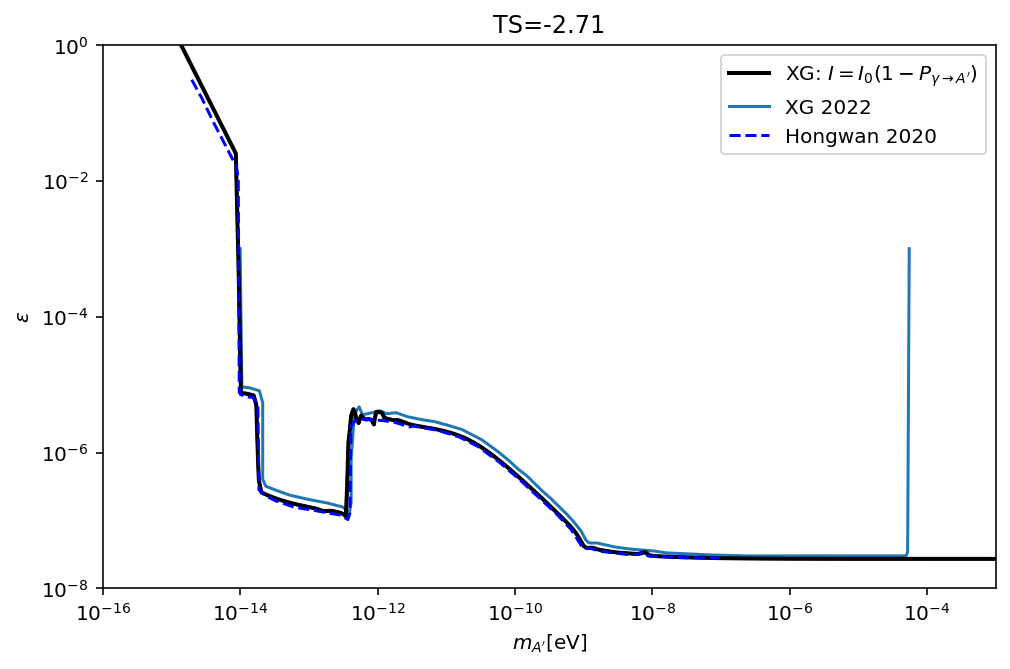

In [21]:
# Xucheng_FIRAS_2Dary    = np.transpose( np.array( pd.read_csv('../data/Xucheng_22_FIRAS.csv') ) )
# Samuel_FIRAS_2Dary     = np.transpose( np.array( pd.read_csv('../data/Samuel_20_FIRAS.csv') ) )
# Hongwan_20_FIRAS_2Dary = np.transpose( np.array( pd.read_csv('../data/Hongwan_20_FIRAS.csv') ) )
# Redondo_09_FIRAS_2Dary = np.transpose( np.array( pd.read_csv('../data/Redondo_09_FIRAS.csv') ) )


# # Delta 95%CL, From PDG Statistics
# # TS_choose = 5.99
# TS_choose = 2.71

# import matplotlib.cm as cm

# X_plt, Y_plt     = np.meshgrid( mAp_1Dary_FIRAS_import, eps_1Dary_FIRAS_import )
# Z_plt_M          = np.log10( TS_2Dary_M_FIRAS_import )

# set_matplotlib_formats('retina')
# plt.figure(figsize=(8,5))


# plt.xscale('log')
# plt.yscale('log')

# CS_M  = plt.contour(X_plt, Y_plt, Z_plt_M,  levels = [ np.log10(TS_choose) ])


# Xucheng_Greens_M  = np.transpose(CS_M.collections[0].get_paths()[0].vertices )

# plt.plot( Xucheng_Greens_M[0]         , Xucheng_Greens_M[1], label = r'XG: $I=I_0 (1-P_{\gamma \rightarrow A^\prime})$', color='black',linewidth=2.0, zorder=5)
# plt.plot( Xucheng_FIRAS_2Dary[0]      , Xucheng_FIRAS_2Dary[1], label = r'XG 2022')
# plt.plot( Hongwan_20_FIRAS_2Dary[0]   , Hongwan_20_FIRAS_2Dary[1], label = r'Hongwan 2020', color = 'blue',linestyle = 'dashed', zorder=10)
# # plt.plot( Redondo_09_FIRAS_2Dary[0] , Redondo_09_FIRAS_2Dary[1], label = r'Redondo 2009', color = 'red')

# # plt.plot( Samuel_FIRAS_2Dary[0]     , Samuel_FIRAS_2Dary[1], label = r'Samuel 2020', color = 'orange')


# plt.title(r'TS=-2.71')

# plt.ylim(1e-8, 1)

# plt.xlabel(r'$m_{A^\prime}$[eV]')
# plt.ylabel(r'$\epsilon$')

# plt.legend()
# # plt.show()

# plt.savefig('FIRAS_Bound_P.pdf')